argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
asttokens==2.0.5
attrs==21.4.0
backcall==0.2.0
beautifulsoup4==4.11.1
bleach==5.0.0
cffi==1.15.0
colorama==0.4.4
cycler==0.11.0
debugpy==1.6.0
decorator==5.1.1
defusedxml==0.7.1
entrypoints==0.4
et-xmlfile==1.1.0
executing==0.8.3
fastjsonschema==2.15.3
fonttools==4.30.0
implicit==0.5.2
importlib-resources==5.7.1
ipykernel==6.12.1
ipython==8.2.0
ipython-genutils==0.2.0
ipywidgets==7.7.0
jedi==0.18.1
Jinja2==3.1.2
joblib==1.1.0
jsonschema==4.6.0
jupyter==1.0.0
jupyter-client==7.2.2
jupyter-console==6.4.3
jupyter-core==4.9.2
jupyterlab-pygments==0.2.2
jupyterlab-widgets==1.1.0
kiwisolver==1.3.2
MarkupSafe==2.1.1
matplotlib==3.5.1
matplotlib-inline==0.1.3
mistune==0.8.4
nbclient==0.6.4
nbconvert==6.5.0
nbformat==5.4.0
nest-asyncio==1.5.5
notebook==6.4.11
numpy==1.22.3
openpyxl==3.0.9
packaging==21.3
pandas==1.4.1
pandocfilters==1.5.0
parso==0.8.3
pexpect==4.8.0
pickleshare==0.7.5
Pillow==9.0.1
prometheus-client==0.14.1
prompt-toolkit==3.0.29

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.metrics import average_precision_score
from tqdm.notebook import tqdm

import implicit

from typing import List

%matplotlib inline

# Сырые данные

## Считываем данные из .csv

Некоторые данные (такие как рубрики и признаки), представлены строками значений. Преобразуем их в списки чисел. 

In [2]:
# Переводит строку вида '1 2 3 4' в список [1, 2, 3, 4].
to_int_list = lambda values: [int(value) for value in str(values).split(' ')]

def apply_to_columns(df: pd.DataFrame, columns: List[str], func=to_int_list):
    """Apply function to the specified columns of the dataframe.
    """

    for column in columns:
        df.loc[~df[column].isnull(), column] = df.loc[
            ~df[column].isnull(), column
        ].apply(func)

В первую очередь нам понадобятся данные по **пользователям**, **организациям** и сами **отзывы**. 

In [3]:
users = pd.read_csv('data/users.csv')
users.head()

,user_id,city
0,36BF53FF2D117FD6B70F11C1C2D2DD88609298CBF80A11...,msk
1,37C79862F940ED4A451304697F61E652FE120C868BBCD5...,msk
2,40279525A675CB54040C01C09A5AEE02794B187E24C204...,msk
3,40DD4DBAEFF1376F92DA3E08D36E3E81A2539228389143...,msk
4,FB01CDD7C500F53CB666EA7B182A5BB940271FCC9BF039...,msk


In [4]:
orgs = pd.read_csv('data/organisations.csv')

In [5]:
# create lists
columns = ['rubrics_id', 'features_id']
apply_to_columns(orgs, columns)

orgs.head()

,org_id,city,average_bill,rating,rubrics_id,features_id
0,DB02713EAD474F7DCB4FAB65333D4D360C6337BFC3CA43...,msk,500.0,4.378378,[30771],"[1509, 10462, 11617, 273469383, 1082283206, 10..."
1,31F077980B0BCC05B17B988E0017B538CE523A2ACB8FEA...,msk,500.0,4.166667,[30519],"[1524, 10462, 11177, 11629, 1018, 11704, 1415,..."
2,B16CB024197B053E9C713A79812ED658CA4B2FB8F5293C...,msk,500.0,3.687500,"[30776, 30771]","[1524, 11629, 1018, 11704, 10462, 12048, 1416,..."
3,25308E05A46D9D40BDB6A6AC55CD422147D40B0B0D44B2...,msk,500.0,3.835417,[30771],"[10462, 3501744275, 3501513153, 20424, 3501618..."
4,D9FB72E2B38AC2A03586074A0019ABA16F7EE761C08120...,msk,500.0,4.750000,[3501750896],"[20282, 20424, 273469383, 11617, 11629, 11177,..."


Чтобы не делать __join__ каждый раз, когда нам потребуется узнать, из какого города организация или пользователь, сразу добавим эту информацию в отзывы.

In [6]:
# Читаем датасет по частям, затем соединяем в один. Позволяет загружать большие
#   (500 мб и более) датасеты.
#   К сожалению, low_memory=True дропает кернел, несмотря на то что внутри
# использует схожий механизм.
# - Количество рядов, содеражихся в одной части датасета.
chunksize = 1000
reviews = pd.concat(pd.read_csv('data/reviews.csv', chunksize=chunksize))
reviews

,user_id,org_id,rating,ts,aspects
0,E5A7AF2BBA62183E969998FFE09A6304F4761BC7445EF8...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,618,NaN
1,26B8CB030A2B279E6804AC6EF20C27D7F7BE0C08129C78...,01074FAE0B11E5A1B74AC2D82CF0B66F2A766C84856B0D...,5.0,525,38 326 8
2,A563C39DB5FE7418D9A6DFE2B412B5D56D94354F57A249...,A9B175ABD408F9C22A1E5DBE40FA1E12A19AB0DB632555...,3.0,992,NaN
3,C3EBA3C3B06DF6D4660FA05F89E6FDC9064AEE854E0F42...,EB920597A31D5A076FE047DEA1B1B5270C2C69A2D4E1FB...,1.0,743,NaN
4,31F3248779160242FDF7382C945F296F236762E53930BB...,61CA13C754EE92C2CAEA47987DEC07889AFD53C52753D6...,4.0,629,NaN
...,...,...,...,...,...
3642378,EC6AD59EE2A8F17D88766A6C6FFBEFF3E0AF5B8C6A552A...,23DAEA2F9F28B6974E14E1C33DA84B7D1B11DAAA5D9150...,5.0,1175,NaN
3642379,C3849F9ED21D47D717FE9EDE5708FFD043A94D95E090D8...,47931E7848316D77CE2B403EEBC9A3020FBECD94FF3A12...,5.0,978,4 11
3642380,CB10C36195B94A74A535612B49DE25B3365BC6F6F0EC4C...,0E062B4975B77F8392246CBFCE27AEAD6F898D117938D8...,2.0,378,NaN
3642381,CB10C36195B94A74A535612B49DE25B3365BC6F6F0EC4C...,0E062B4975B77F8392246CBFCE27AEAD6F898D117938D8...,2.0,378,NaN


In [7]:
# Join по user_id.
reviews = reviews.merge(users, on='user_id')
reviews = reviews.rename({'city': 'user_city'}, axis=1)

# Join по org_id.
reviews = reviews.merge(orgs[['org_id', 'city']], on='org_id')
reviews = reviews.rename({'city': 'org_city'}, axis=1)

# В колонке aspects тоже находятся записи вида '1 2 3', приведём их к числовому
#   списку.
columns = ['aspects']
apply_to_columns(reviews, columns)

reviews.head()

,user_id,org_id,rating,ts,aspects,user_city,org_city
0,E5A7AF2BBA62183E969998FFE09A6304F4761BC7445EF8...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,618,NaN,msk,msk
1,9EE61FA268028BF20A1B320A880A39C8980D3744818773...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,817,NaN,msk,msk
2,CD2B195CD844F1288549EA7FC328AD45D8CAB75CA774D0...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,514,NaN,msk,msk
3,77355B0BE48A8AE2CD32D7344DB51B86ECD585CAC920CA...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,3.0,1080,NaN,msk,msk
4,FE35FCFAA71FFA5B3E8E8A91B7A8676D5AC89A474DC9DA...,689F4C0B84691F6FC69368EDF6E426BEAC543C799F56F2...,5.0,776,NaN,msk,msk


Отлично, теперь с отзывами будет удобно работать. 

Посмотрим на распределение новых отзывов по дням, чтобы понять, как лучше организовать валидацию. 

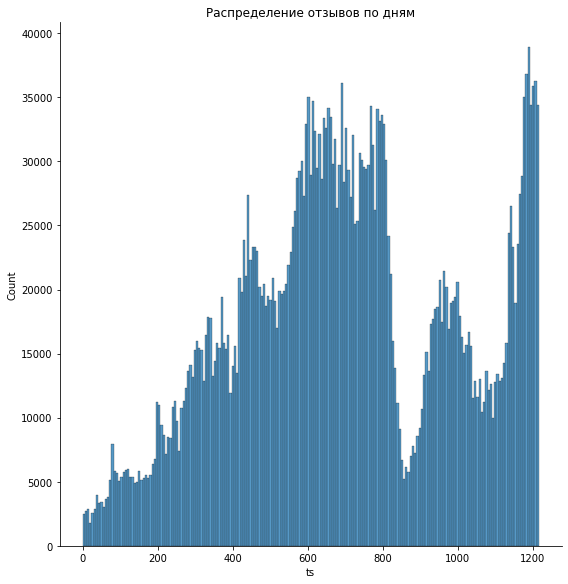

In [8]:
sns.displot(data=reviews, x='ts', height=8)
plt.title('Распределение отзывов по дням')
plt.show()

# Train-test split

In [9]:
def clear_df(df, suffixes=['_x', '_y'], inplace=True):
    '''
    clear_df(df, suffixes=['_x', '_y'], inplace=True)
        Удаляет из входного df все колонки, оканчивающиеся на заданные суффиксы. 
        
        Parameters
        ----------
        df : pandas.DataFrame
        
        suffixies : Iterable, default=['_x', '_y']
            Суффиксы колонок, подлежащих удалению
            
        inplace : bool, default=True
            Нужно ли удалить колонки "на месте" или же создать копию DataFrame.
            
        Returns
        -------
        pandas.DataFrame (optional)
            df с удалёнными колонками
    '''
    
    def bad_suffix(column):
        nonlocal suffixes
        return any(column.endswith(suffix) for suffix in suffixes)
        
    columns_to_drop = [col for col in df.columns if bad_suffix(col)]
    return df.drop(columns_to_drop, axis=1, inplace=inplace)


def extract_unique(reviews, column): 
    '''
    extract_unique(reviews, column)
        Извлекает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит одну именованную колонку с уникальными значениями. 
    '''
    
    unique = reviews[column].unique()
    return pd.DataFrame({column: unique})


def count_unique(reviews, column):
    '''
    count_unique(reviews, column)
        Извлекает и подсчитывает уникальные значения из колонки в DataFrame.
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            pandas.DataFrame, из которого будут извлечены значения.
        
        column : str
            Имя колонки в <reviews>.
        
        Returns
        -------
        pandas.DataFrame
            Содержит две колонки: с уникальными значениями и счётчиком встреченных. 
    '''
    
    return reviews[column].value_counts().reset_index(name='count').rename({'index': column}, axis=1)



def filter_reviews(reviews, users=None, orgs=None): 
    '''
    filter_reviews(reviews, users=None, orgs=None)
    Оставляет в выборке только отзывы, оставленные заданными пользователями на заданные организации. 
    
    Parameters
    ----------
        users: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <user_id>.
            Если None, то фильтрация не происходит. 
            
        orgs: pandas.DataFrame, default=None
            DataFrame, содержащий колонку <org_id>.
            Если None, то фильтрация не происходит. 
    
    Returns
    -------
        pandas.DataFrame
            Отфильтрованная выборка отзывов. 

    '''
    if users is not None: 
        reviews = reviews.merge(users, on='user_id', how='inner')
        clear_df(reviews)
        
    if orgs is not None:
        reviews = reviews.merge(orgs, on='org_id', how='inner')
        clear_df(reviews)
        
    return reviews


def train_test_split(reviews, ts_start, ts_end=None):
    '''
    train_test_split(reviews, ts_start, ts_end=None)
        Разделяет выборку отзывов на две части: обучающую и тестовую. 
        В тестовую выборку попадают только отзывы с user_id и org_id, встречающимися в обучающей выборке.

        Parameters
        ----------
        reviews : pandas.DataFrame 
            Отзывы из reviews.csv с обязательными полями:
                <rating>, <ts>, <user_id>, <user_city>, <org_id>, <org_city>.

        ts_start : int
            Первый день отзывов из тестовой выборки (включительно).

        ts_end : int, default=None
            Последний день отзывов из обучающей выборки (включительно)
            Если параметр равен None, то ts_end == reviews['ts'].max(). 

        Returns
        -------
        splitting : tuple
            Кортеж из двух pandas.DataFrame такой же структуры, как и reviews:
            в первом отзывы, попавшие в обучающую выборку, во втором - в тестовую.
    '''
    
    if not ts_end:
        ts_end = reviews['ts'].max()
    
    
    reviews_train = reviews[(reviews['ts'] < ts_start) | (reviews['ts'] > ts_end)]
    reviews_test = reviews[(ts_start <= reviews['ts']) & (reviews['ts'] <= ts_end)]
    
    # 1. Выбираем только отзывы на понравившиеся места у путешественников
    reviews_test = reviews_test[reviews_test['rating'] >= 4.0]
    user_and_org_from_different_cities = reviews_test['org_city'] != reviews_test['user_city']
    reviews_test = reviews_test[user_and_org_from_different_cities]
    
    # 2. Оставляем в тесте только тех пользователей и организации, которые встречались в трейне
    train_orgs = extract_unique(reviews_train, 'org_id')
    train_users = extract_unique(reviews_train, 'user_id')
    
    reviews_test = filter_reviews(reviews_test, orgs=train_orgs)

    return reviews_train, reviews_test


def process_reviews(reviews):
    '''
    process_reviews(reviews)
        Извлекает из набора отзывов тестовых пользователей и таргет. 
        
        Parameters
        ----------
        reviews : pandas.DataFrame
            DataFrame с отзывами, содержащий колонки <user_id> и <org_id>
        
        Returns
        -------
        X : pandas.DataFrame
            DataFrame такой же структуры, как и в test_users.csv
            
        y : pandas.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список org_id, посещённых пользователем. 
    '''
    
    y = reviews.groupby('user_id')['org_id'].apply(list).reset_index(name='target')
    X = pd.DataFrame(y['user_id'])
    
    return X, y

In [10]:
reviews['ts'].max()

1216

Всего в выборку попали отызывы за **1216** дней. 

Отложим в тестовую выборку отзывы за последние **100** дней.

In [11]:
train_reviews, test_reviews = train_test_split(reviews, 1116)
X_test, y_test = process_reviews(test_reviews)

Посмотрим, сколько всего уникальных пользователей попало в эту тестовую выборку:

In [12]:
len(X_test)

11978

# Метрика

Метрика принимает на вход два DataFrame, имеющих такую же структуру, как и **y_test**.
Вычисляется Precision, в контексте рекомендательных систем формула выглядит
следующим образом: 
$$
\begin{align*}
  \qquad P = \frac{\textrm{Количество релевантных рекомендаций}}{\textrm{Количество рекомендаций}}
\end{align*}
$$

Далее берётся Average Precision:

$$
\begin{align*}
  \textrm{AP@N} = \frac{1}{m}\sum_{k=1}^N \textrm{($P(k)$ если $k_{ая}$ рекомендация была релевантна)} = \frac{1}{m}\sum_{k=1}^N P(k)\cdot rel(k),
\end{align*}
$$
где m - количество рекомендаций, N - количество рекомендаций, которые мы
берём в расчёт $ N \leq m $

В конечном итоге, нас интересует Mean Average Precision - среднее Average
Precision по пользователям:
$$
\begin{align*}
  \textrm{MAP@N} = \frac{1}{|U|}\sum_{u=1}^|U|(\textrm{AP@N})_u = \frac{1}{|U|} \sum_{u=1}^|U| \frac{1}{m}\sum_{k=1}^N P_u(k)\cdot rel_u(k).
\end{align*}
$$

In [13]:
def mean_average_precision_at_n(size=20):
    '''
    mean_average_precision_at_n(size=20)
        Создаёт метрику под <size> сделанных предсказаний.
        
        Parameters
        ----------
        size : int, default=20
            Размер рекомендованной выборки для каждого пользователя
        
        Returns
        -------
        func(pd.DataFrame, pd.DataFrame) -> float
            Функция, вычисляющая mean_average_precision_at_n.
        
    '''
    
    assert size >= 1, "Size must be greater than zero!"
    
    def metric(y_true, predictions, size=size):
        '''
        metric(y_true, predictions, size=size)
            Метрика mean_average_precision_at_n для двух перемешанных наборов <y_true> и <y_pred>.
            
            Parameters
            ----------
            y_true : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список настоящих org_id, посещённых пользователем. 
                
            predictions : pd.DataFrame
                DataFrame с колонками <user_id> и <target>. 
                В <target> содержится список рекомендованных для пользователя org_id.
                
            Returns
            -------
            float 
                Значение метрики.
        '''
        
        y_true = y_true.rename({'target': 'y_true'}, axis='columns')
        predictions = predictions.rename({'target': 'predictions'}, axis='columns')
        
        merged = y_true.merge(predictions, left_on='user_id', right_on='user_id')
    
        def average_precision_for_user(x: pd.DataFrame, size=size) -> float:
            '''
            average_precision_for_user(x: pd.DataFrame, size=size) -> float
            Средняя точность для пользователя.

            Parameters
            ----------
            x : pd.DataFrame
                DataFrame с колонками <user_id>, <y_true>, <predictions>.

            Returns
            -------
            float
                Значение от 0 до 1 - средняя точность для пользователя.
            '''
            y_true = x[1][1]
            predictions = x[1][2]
            
            weight = 0
            
            inner_weights = [0]
            for n, item in enumerate(predictions):
                inner_weight = inner_weights[-1] + (1 if item in y_true else 0)
                inner_weights.append(inner_weight)
            
            for n, item in enumerate(predictions):                
                if item in y_true:
                    weight += inner_weights[n + 1] / (n + 1)
                    
            return weight / min(len(y_true), size)

        return np.mean([average_precision_for_user(user_row) for user_row in merged.iterrows()])
    
        
    return metric


def print_score(score):
    print(f"Score: {score:.6f}")
    
    
N = 20
mapN = mean_average_precision_at_n(N)

# Подходы без машинного обучения

## Случайные N мест

Попробуем предлагать пользователям случайные места из другого города. 

In [14]:
spb_orgs = orgs[orgs['city'] == 'spb']['org_id']
msk_orgs = orgs[orgs['city'] == 'msk']['org_id']

test_users_with_locations = X_test.merge(users, on='user_id')

In [15]:
%%time

np.random.seed(1337)
choose = lambda x: np.random.choice(spb_orgs, N) if x['user_id'] == 'msk' else np.random.choice(msk_orgs, N)
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(mapN(y_test, predictions))

Score: 0.000035
CPU times: user 2.99 s, sys: 204 ms, total: 3.2 s
Wall time: 3.08 s


## N самых популярных мест

Предыдущий подход, очевидно, не очень удачно предсказывает, какие места посетит пользователей. 

Попробуем улучшить стратегию: будем предлагать пользователям самые популярные места, то есть те, на которые оставлено больше всего отзывов. 

In [16]:
msk_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'msk')]['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = train_reviews[(train_reviews['rating'] >= 4) & (train_reviews['org_city'] == 'spb')]['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [17]:
%%time

choose = lambda x: spb_orgs if x['user_id'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(mapN(y_test, predictions))

Score: 0.004885
CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.02 s


Отлично, метрика немного улучшилась. Но стоит попробовать доработать эту тактику. 

## N самых популярных мест среди туристов

In [18]:
tourist_reviews = train_reviews[train_reviews['rating'] >= 4.0]

# набор отзывов только от туристов
tourist_reviews = tourist_reviews[tourist_reviews['user_city'] != tourist_reviews['org_city']]

# выбираем самые популярные места среди туристов из Москвы и Питера
msk_orgs = tourist_reviews[tourist_reviews['org_city'] == 'msk']['org_id']
msk_orgs = msk_orgs.value_counts().index[:N].to_list()

spb_orgs = tourist_reviews[tourist_reviews['org_city'] == 'spb']['org_id']
spb_orgs = spb_orgs.value_counts().index[:N].to_list()

In [19]:
%%time

choose = lambda x: spb_orgs if x['user_id'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(mapN(y_test, predictions))

Score: 0.008885
CPU times: user 1.55 s, sys: 0 ns, total: 1.55 s
Wall time: 1.55 s


Метрика улучшилась ещё немного.

## N / rubrics_count самых популярных мест из каждой рубрики

In [20]:
def extract_top_by_rubrics(reviews, N):
    '''
    extract_top_by_rubrics(reviews, N)
        Набирает самые популярные организации по рубрикам, сохраняя распределение.
        
        Parameters
        ----------
        reviews : pd.DataFrame
            Отзывы пользователей для рекомендации.
            
        N : int
            Число рекомендаций.
        
        Returns
        -------
        orgs_list : list
            Список отобранных организаций.
    '''
    
    # Извлечение популярных рубрик.
    reviews = reviews.merge(orgs, on='org_id')[['org_id', 'rubrics_id']]
    
    rubrics = reviews.explode('rubrics_id').groupby('rubrics_id').size()
    rubrics = (rubrics / rubrics.sum() * N).apply(round).sort_values(ascending=False)

    # Вывод списка рубрик по убыванию популярности.
    print(
        pd.read_csv('data/rubrics.csv')
        .merge(rubrics.reset_index(), left_index=True, right_on='rubrics_id')
        .sort_values(by=0, ascending=False)[['rubric_id', 0]]
    )
    
    # извлечение популярных организаций
    train_orgs = reviews.groupby('org_id').size().reset_index(name='count').merge(orgs, on='org_id')
    train_orgs = train_orgs[['org_id', 'count', 'rubrics_id']]

    most_popular_rubric = lambda rubrics_id: max(rubrics_id, key=lambda rubric_id: rubrics[rubric_id])
    train_orgs['rubrics_id'] = train_orgs['rubrics_id'].apply(most_popular_rubric)
    
    orgs_by_rubrics = train_orgs.sort_values(by='count', ascending=False).groupby('rubrics_id')['org_id'].apply(list)
    
    # соберём самые популярные организации в рубриках в один список
    
    orgs_list = []

    for rubric_id, count in zip(rubrics.index, rubrics):
        if rubric_id not in orgs_by_rubrics:
            continue 

        orgs_list.extend(orgs_by_rubrics[rubric_id][:count])
    
    return orgs_list


msk_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

                      rubric_id  0
0                      Ресторан  7
1                          Кафе  6
2                          Бар\  2
3               Быстрое питание  2
4                       Кофейня  1
5                     Булочная\  0
6                      Пиццерия  0
7                      Столовая  0
8                      Спортбар  0
9                  Кондитерская  0
10                     Суши-бар  0
11                   Кальян-бар  0
12  Бар безалкогольных напитков  0
13                      Фудкорт  0
14                 Кофе с собой  0
                      rubric_id  0
0                      Ресторан  9
1                          Кафе  5
2                          Бар\  2
3                     Булочная\  1
4               Быстрое питание  1
5                  Кондитерская  1
6                       Кофейня  1
7                      Пиццерия  0
8                      Столовая  0
9                      Спортбар  0
10                     Суши-бар  0
11                  

In [21]:
%%time

choose = lambda x: spb_orgs if x['user_id'] == 'msk' else msk_orgs
target = test_users_with_locations.apply(choose, axis=1)

predictions = X_test.copy()
predictions['target'] = target

print_score(mapN(y_test, predictions))

Score: 0.009543
CPU times: user 1.35 s, sys: 0 ns, total: 1.35 s
Wall time: 1.34 s


# ML методы. Коллаборативная фильтрация

## Memory-based

Для этой группы методов требуется явное построение матрицы __пользователь-организация__ (__interaction matrix__), где на пересечении $i$-ой строки и $j$-ого столбца будет рейтинг, который $i$-ый пользователь выставил $j$-ой организации или же пропуск, если рейтинг не был установлен. 

In [22]:
def reduce_reviews(reviews, min_user_reviews=5, min_org_reviews=13):
    '''
    reduce_reviews(reviews, min_user_reviews=5, min_org_reviews=13)
        Убирает из выборки пользователей и организации, у которых менее <min_reviews> отзывов в родном городе. 
        Оставляет только отзывы туристов. 
        
        Parameters
        ----------
        reviews : pandas.DataFrame 
            Выборка отзывов с обязательными полями:
                <user_id>, <user_city>.
        
        min_user_reviews : int, default=5
            Минимальное количество отзывов у пользователя, необходимое для включения в выборку.
            
        min_org_reviews : int, default=13
            Минимальное количество отзывов у организации, необходимое для включения в выборку.
            
        Returns
        -------
        splitting : tuple
            Кортеж из двух наборов.
            Каждый набор содержит 2 pandas.DataFrame:
                1. Урезанная выборка отзывов
                2. Набор уникальных организаций
                
            Первый набор содержит DataFrame-ы, относящиеся к отзывам, оставленным в родном городе, а второй -
            к отзывам, оставленным в чужом городе. ё
            
        users : pd.DataFrame
            Набор уникальных пользователей в выборке
        
    '''
    
    inner_reviews = reviews[reviews['user_city'] == reviews['org_city']]
    outer_reviews = reviews[reviews['user_city'] != reviews['org_city']]

    # оставляем только отзывы туристов на родной город 
    tourist_users = extract_unique(outer_reviews, 'user_id')
    inner_reviews = filter_reviews(inner_reviews, users=tourist_users)
    
    # выбираем только тех пользователей и организации, у которых есть <min_reviews> отзывов
    top_users = count_unique(inner_reviews, 'user_id')
    top_users = top_users[top_users['count'] >= min_user_reviews]
        
    top_orgs = count_unique(inner_reviews, 'org_id')
    top_orgs = top_orgs[top_orgs['count'] >= min_org_reviews]
        
    inner_reviews = filter_reviews(inner_reviews, users=top_users, orgs=top_orgs)
    outer_reviews = filter_reviews(outer_reviews, users=top_users)
    
    # combine reviews
    reviews = pd.concat([inner_reviews, outer_reviews])
    users = extract_unique(reviews, 'user_id')
    orgs = extract_unique(reviews, 'org_id')
    
    
    return (
        (
            inner_reviews,
            extract_unique(inner_reviews, 'org_id')
        ),
        (
            outer_reviews,
            extract_unique(outer_reviews, 'org_id')
        ),
        extract_unique(inner_reviews, 'user_id')
    )

In [23]:
def create_mappings(df, column):
    '''
    create_mappings(df, column)
        Создаёт маппинг между оригинальными ключами словаря и новыми порядковыми.
        
        Parameters
        ----------
        df : pandas.DataFrame
            DataFrame с данными.
            
        column : str
            Название колонки, содержащей нужны ключи. 
        
        Returns
        -------
        code_to_idx : dict
            Словарь с маппингом: "оригинальный ключ" -> "новый ключ".
        
        idx_to_code : dict
            Словарь с маппингом: "новый ключ" -> "оригинальный ключ".
    '''
    
    code_to_idx = {}
    idx_to_code = {}
    
    for idx, code in enumerate(df[column].to_list()):
        code_to_idx[code] = idx
        idx_to_code[idx] = code
        
    return code_to_idx, idx_to_code


def map_ids(row, mapping):
    '''
    Вспомогательная функция
    '''
    
    return mapping[row]


def interaction_matrix(reviews, test_users, min_user_reviews=5, min_org_reviews=12): 
    '''
    interaction_matrix(reviews, test_users, min_user_reviews=5, min_org_reviews=12)
        Создаёт блочную матрицу взаимодействий (вид матрицы описан в Returns)
        
        Parameters
        ----------
        reviews : pd.DataFrame
            Отзывы пользователей для матрицы взаимодействий.
            
        test_users : pd.DataFrame
            Пользователи, для которых будет выполнятся предсказание. 
        
        min_user_reviews : int, default=5
            Минимальное число отзывов от пользователя, необходимое для включения его в матрицу.
        
        min_org_reviews : int, default=12
            Минимальное число отзывов на организацию, необходимое для включения её в матрицу.
    
        Returns
        -------
        InteractionMatrix : scipy.sparse.csr_matrix
            Матрица, содержащая рейтинги, выставленные пользователями.
            Она блочная и имеет такой вид:
                 ---------------------------------------------------
                | TRAIN USERS, INNER ORGS | TRAIN USERS, OUTER ORGS |
                |                         |                         |
                 ---------------------------------------------------
                |  TEST USERS, INNER ORGS |  TEST USERS, OUTER ORGS |
                |                         |                         |
                 ---------------------------------------------------

        splitting : tuple
            Кортеж, содержащий два целых числа: 
                1. Число пользователей в обучающей выборке 
                2. Число организаций в домашнем регионе

        splitting: tuple
            Кортеж, содержащий два котрежа из двух словарей:
                1. (idx_to_uid, uid_to_idx) - содержит маппинг индекса к user_id
                2. (idx_to_oid, oid_to_idx) - содержит маппинг индекса к org_id
    '''
    
    
    info = reduce_reviews(train_reviews, min_user_reviews, min_org_reviews)
    (inner_reviews, inner_orgs), (outer_reviews, outer_orgs), train_users = info
    
    # удалим из обучающей выборки пользователей, которые есть в тестовой
    test_users = test_users[['user_id']]
    
    train_users = (
        pd.merge(train_users, test_users, indicator=True, how='outer')
        .query('_merge=="left_only"')
        .drop('_merge', axis=1)
    )
    
    inner_reviews = filter_reviews(inner_reviews, train_users)
    outer_reviews = filter_reviews(outer_reviews, train_users)
    
    # оставляем отзывы, оставленные тестовыми пользователями
    test_reviews = filter_reviews(reviews, test_users, pd.concat([inner_orgs, outer_orgs]))
    
    # получаем полный набор маппингов
    all_users = pd.concat([train_users, test_users])
    all_orgs = pd.concat([inner_orgs, outer_orgs])
    
    uid_to_idx, idx_to_uid = create_mappings(all_users, 'user_id')
    oid_to_idx, idx_to_oid = create_mappings(all_orgs, 'org_id')
    
    # собираем матрицу взаимодействий 
    reviews = pd.concat([inner_reviews, outer_reviews, test_reviews])    
        
    I = reviews['user_id'].apply(map_ids, args=[uid_to_idx]).values
    J = reviews['org_id'].apply(map_ids, args=[oid_to_idx]).values
    values = reviews['rating']
        
    interactions = sparse.coo_matrix(
        (values, (I, J)), 
        shape=(len(all_users), len(all_orgs)), 
        dtype=np.float64
    ).tocsr()
    
    
    return (
        interactions, 
        (len(train_users), len(inner_orgs)), 
        (
            (idx_to_uid, uid_to_idx),
            (idx_to_oid, oid_to_idx)
        )
    )

## Alternating Least Squares
Метод не столь точный как градиентный спуск, но достаточно эффективный:
главным достоинством является скорость, даже на больших данных показывает
хорошие результаты [1].

In [24]:
%%time
def make_predictions(interactions, X_test, N):
    '''
    make_predictions(interactions, X_test, N)
        Делает рекомендации для пользователей из <X_test> на основе матрицы взаимодействий. 
        
        Parameters
        ----------
        interactions : scipy.sparse.csr_matrix
            Разреженная матрица взаимодействий.
            
        X_test : pd.DataFrame
            Набор тестовых пользователей, для которых нужно сделать рекомендации. 
        
        N : int
            Число рекомендаций для каждого пользователя. 
        
        Returns
        -------
        predictions : pd.DataFrame
            DataFrame с колонками <user_id> и <target>. 
            В <target> содержится список рекомендованных для пользователя org_id.
        
        
    '''
    
    predictions = X_test[['user_id']].copy()
    predictions['target'] = pd.Series(dtype=object)
    predictions = predictions.set_index('user_id')
    
    interactions, (train_users_len, inner_orgs_len), mappings = interactions
    (idx_to_uid, uid_to_idx), (idx_to_oid, oid_to_idx) = mappings

    base_model = AlternatingLeastSquares(
        factors=5, 
        iterations=75, 
        regularization=0.05, 
        random_state=42
    )
    
    base_model.fit(interactions.T)
    
    orgs_to_filter = list(np.arange(inner_orgs_len))

    recommendations = base_model.recommend_all(
        interactions,
        N=N,
        filter_already_liked_items=True,
        filter_items=orgs_to_filter,
        show_progress=True
    )
    
    for user_id in tqdm(X_test['user_id'].values, leave=False):
        predictions.loc[user_id, 'target'] = list(
            map(
                lambda org_idx: idx_to_oid[org_idx], 
                recommendations[uid_to_idx[user_id]]
            )
        )
        
    return predictions.reset_index()


msk_interactions = interaction_matrix(
    train_reviews[train_reviews['user_city'] == 'msk'],
    test_users_with_locations[test_users_with_locations['city'] == 'msk'],
)

spb_interactions = interaction_matrix(
    train_reviews[train_reviews['user_city'] == 'spb'],
    test_users_with_locations[test_users_with_locations['city'] == 'spb'],
)       
        
test_msk_users = test_users_with_locations[test_users_with_locations['city'] == 'msk']
test_spb_users = test_users_with_locations[test_users_with_locations['city'] == 'spb']

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

['/mnt/e/Projects/--educational/Bomonka/__MachineLearning/Article@RecommendationSystems',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/home/dubuntus/.local/lib/python3.8/site-packages',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages']

In [26]:
%%time

print_score(mapN(y_test, predictions))

Score: 0.009543
CPU times: user 875 ms, sys: 0 ns, total: 875 ms
Wall time: 871 ms


Источники
1. **Ким Фалк** - Практические рекомендательные системы.

# Submission

Выберем лучший метод на валидации, переобучим его на всей выборке и сделаем предсказание на тестовой выборке. 

## Without ML

In [27]:
test_users = pd.read_csv('data/test_users.csv')
test_users['city'] = test_users.merge(users, on='user_id')['city']

tourist_reviews = reviews[(reviews['ts'] > 900) & (reviews['user_city'] != reviews['org_city'])]

msk_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'msk'], N)
spb_orgs = extract_top_by_rubrics(tourist_reviews[tourist_reviews['org_city'] == 'spb'], N)

msk_orgs = str(' '.join(map(str, msk_orgs)))
spb_orgs = str(' '.join(map(str, spb_orgs)))

                      rubric_id  0
0                      Ресторан  7
1                          Кафе  6
2                          Бар\  2
3               Быстрое питание  2
4                       Кофейня  1
5                     Булочная\  0
6                      Пиццерия  0
7                      Столовая  0
8                      Спортбар  0
9                  Кондитерская  0
10                     Суши-бар  0
11                   Кальян-бар  0
12  Бар безалкогольных напитков  0
13                      Фудкорт  0
14                 Кофе с собой  0
                      rubric_id  0
0                      Ресторан  8
1                          Кафе  5
2                          Бар\  2
3                     Булочная\  1
4               Быстрое питание  1
5                  Кондитерская  1
6                       Кофейня  1
7                      Пиццерия  0
8                      Столовая  0
9                      Спортбар  0
10                     Суши-бар  0
11                  

In [28]:
choose = lambda x: spb_orgs if x['user_id'] == 'msk' else msk_orgs
target = test_users.apply(choose, axis=1)

predictions = test_users[['user_id']]
predictions['target'] = target

predictions.head()

,user_id,target
0,90D2A9DFBDAD40BB75BC59AC58E8B95747053032E4509E...,2222B053F2FD204B6223381E5AC0BFA93243A77EBB8067...
1,103E11B48354F3B433CA3B306DDA42C389746B8C222FEE...,2222B053F2FD204B6223381E5AC0BFA93243A77EBB8067...
2,0D50CF6721F931B1A7EF0F0FA50BCA549EC1B49D1F7751...,2222B053F2FD204B6223381E5AC0BFA93243A77EBB8067...
3,8BCC6FC28B5894682080DBFDBD16A7F4A15B153D141BA9...,2222B053F2FD204B6223381E5AC0BFA93243A77EBB8067...
4,287CCD6CA6AE11CC952459BB1FEF7882AB5375B5F7EC79...,2222B053F2FD204B6223381E5AC0BFA93243A77EBB8067...


In [29]:
predictions.to_csv('answers.csv', index=None)

## With ML

In [30]:
test_users = pd.read_csv('data/test_users.csv')
test_users = test_users.merge(users, on='user_id')


test_msk_users = test_users[test_users['city'] == 'msk'][['user_id', 'city']]
test_spb_users = test_users[test_users['city'] == 'spb'][['user_id', 'city']]


msk_interactions = interaction_matrix(
    reviews[reviews['user_city'] == 'msk'],
    test_msk_users
)

spb_interactions = interaction_matrix(
    reviews[reviews['user_city'] == 'spb'],
    test_spb_users
)

msk_predictions = make_predictions(msk_interactions, test_msk_users, N)
spb_predictions = make_predictions(spb_interactions, test_spb_users, N)

predictions = pd.concat([msk_predictions, spb_predictions])

NameError: name 'make_predictions' is not defined

In [ ]:
predictions['target'] = predictions['target'].apply(lambda orgs: ' '.join(map(str, orgs)))
predictions.head()

In [ ]:
predictions.to_csv('answers_ml.csv', index=None)

In [ ]:
import requests 

In [ ]:
r = requests.get('https://api.github.com/events')

In [ ]:
import json 
events = json.loads(r.text)